In [96]:
!wget http://cs301.pintoenterprisetech.com/out.csv

--2021-11-10 23:05:34--  http://cs301.pintoenterprisetech.com/out.csv
Resolving cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)... 157.245.119.43, 2604:a880:800:10::904:6001
Connecting to cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)|157.245.119.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78336 (76K) [text/csv]
Saving to: ‘out.csv.2’

out.csv.2           100%[===================>]  76.50K   215KB/s    in 0.4s    

2021-11-10 23:05:35 (215 KB/s) - ‘out.csv.2’ saved [78336/78336]



In [137]:
import pandas as pd
import datetime

In [98]:
df = pd.read_csv("out.csv")

In [277]:
GMEdf = df.drop(['timekey', 'ticker'], axis=1).rename(columns={"timestamp" : "ds", "avg(sentiment)" : "avg(sentiment)"})

In [279]:
GMEdf.head()

,ds,avg(sentiment)
0,2021-10-31 02:48:20,0.020940
1,2021-10-31 02:51:21,0.339265
2,2021-10-31 03:03:52,0.375158
3,2021-10-31 03:10:07,0.181590
4,2021-10-31 03:20:05,-0.014369


In [280]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [281]:
GMEpricesDf = pd.read_csv('/content/drive/MyDrive/GME.csv')
GMEpricesDf['Date'] = pd.to_datetime(GMEpricesDf['Date'])
GMEpricesDf.set_index('Date', inplace=True)
GMEpricesDf = GMEpricesDf.resample('D').pad()
def populate_target_prices(ds):
  date = datetime.datetime.strptime(ds, "%Y-%m-%d %H:%M:%S")
  date1 = date+datetime.timedelta(days=1)
  if date.hour < 16:
    try:
      return GMEpricesDf.loc[date.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  else:
    try:
      return GMEpricesDf.loc[date1.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  #https://www.programiz.com/python-programming/datetime/strptime

In [282]:
GMEpricesDf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,182.529999,208.570007,182.050003,200.089996,200.089996,4944200
2021-11-02,199.350006,211.940002,191.690002,206.990005,206.990005,3882300
2021-11-03,214.000000,255.690002,208.250000,218.330002,218.330002,11265600
2021-11-04,222.000000,228.970001,211.550003,217.839996,217.839996,2908000
2021-11-05,220.639999,221.000000,209.009995,213.250000,213.250000,1809100
2021-11-06,220.639999,221.000000,209.009995,213.250000,213.250000,1809100
2021-11-07,220.639999,221.000000,209.009995,213.250000,213.250000,1809100
2021-11-08,212.500000,225.039993,212.009995,218.639999,218.639999,2157900
2021-11-09,222.000000,223.490005,204.440002,206.600006,206.600006,1845300


In [286]:
GMEdf['test'] = GMEdf['ds'].apply(populate_target_prices)
GMEdf.loc[0, 'test'] = 200.089996
GMEdf = GMEdf.ffill()

In [287]:
GMEdf

,ds,avg(sentiment),test
0,2021-10-31 02:48:20,0.020940,200.089996
1,2021-10-31 02:51:21,0.339265,200.089996
2,2021-10-31 03:03:52,0.375158,200.089996
3,2021-10-31 03:10:07,0.181590,200.089996
4,2021-10-31 03:20:05,-0.014369,200.089996
...,...,...,...
1535,2021-11-10 18:30:09,0.202564,206.600006
1536,2021-11-10 18:40:02,0.188525,206.600006
1537,2021-11-10 18:50:03,0.394811,206.600006
1538,2021-11-10 19:00:00,0.319333,206.600006


```
load historical prices
if time is earlier than 4pm, close = close(date)
  else close = close(date+1)
    if date+1 does not exist then close(date)


# Python
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)
```



In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

First get future sentiment values

In [377]:
sentiment_m = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=.1, seasonality_mode='additive')
sentiment_m.fit(GMEdf[['ds', 'avg(sentiment)']].rename(columns={'ds':'ds', 'avg(sentiment)':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [384]:
sentiment_future = sentiment_m.make_future_dataframe(periods=100, freq='H')
sentiment_future.tail()
sentiment_forecast = sentiment_m.predict(future)
sentiment_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1635,2021-11-14 19:10:02,0.348573,0.193179,0.494704
1636,2021-11-14 20:10:02,0.348671,0.194756,0.493413
1637,2021-11-14 21:10:02,0.352447,0.193606,0.520427
1638,2021-11-14 22:10:02,0.356906,0.196873,0.517108
1639,2021-11-14 23:10:02,0.359991,0.193397,0.511408


In [385]:
pd.to_datetime(sentiment_forecast.iloc[0]['ds']).strftime("%Y-%m-%d")
sentiment_forecast.index = pd.to_datetime(sentiment_forecast.ds)

Add sentiment as additional regressor

In [391]:
m = Prophet(changepoint_prior_scale=0.005, seasonality_prior_scale=.1, seasonality_mode='additive')
m.add_regressor('avg(sentiment)')
m.fit(GMEdf[['ds', 'test', 'avg(sentiment)']].rename(columns={'ds':'ds', 'test':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [392]:
def fillsentiment(ds):
  return sentiment_forecast.loc[pd.to_datetime(ds), 'yhat']

In [393]:
future = m.make_future_dataframe(periods=100, freq='H')
future['avg(sentiment)'] = future['ds'].apply(fillsentiment)
future.tail()

,ds,avg(sentiment)
1635,2021-11-14 19:10:02,0.348573
1636,2021-11-14 20:10:02,0.348671
1637,2021-11-14 21:10:02,0.352447
1638,2021-11-14 22:10:02,0.356906
1639,2021-11-14 23:10:02,0.359991


In [394]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1635,2021-11-14 19:10:02,186.081204,172.047084,199.649285
1636,2021-11-14 20:10:02,185.721825,172.021088,200.320085
1637,2021-11-14 21:10:02,185.413894,171.340470,199.496471
1638,2021-11-14 22:10:02,185.193783,170.307406,200.428313
1639,2021-11-14 23:10:02,185.023402,171.162003,199.396035


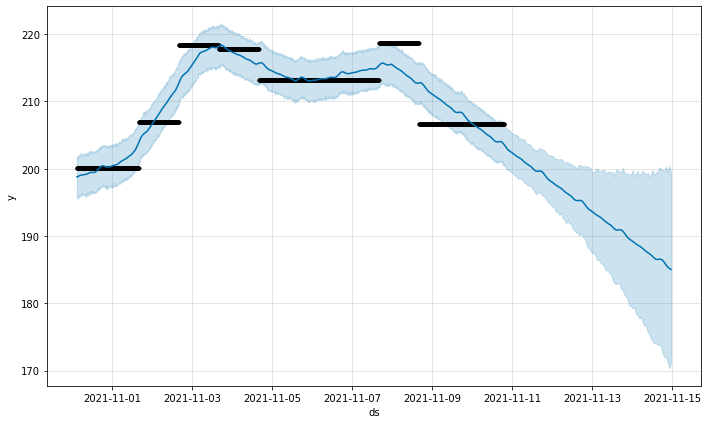

In [395]:
fig1 = m.plot(forecast)

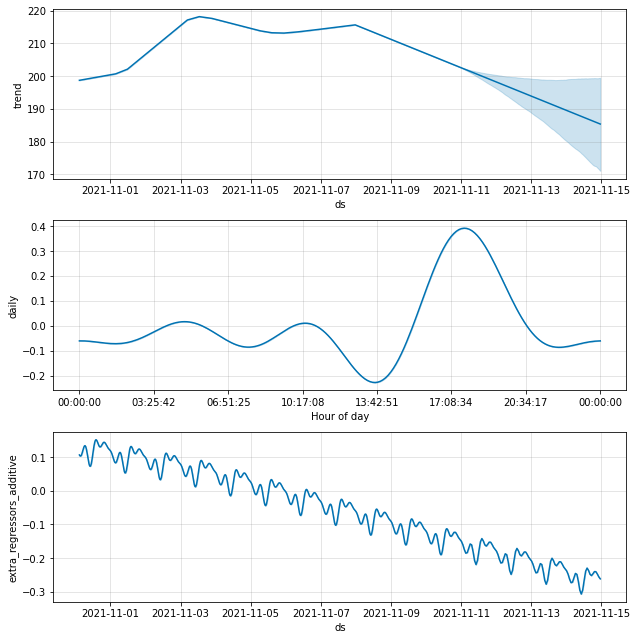

In [396]:
fig2 = m.plot_components(forecast)

In [397]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [398]:
plot_components_plotly(m, forecast)